In [5]:
!pip install ftfy
!pip install pydot

  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/7f/90/c9b51f3cdff89cd8f93382060330f43d1af098a6624cff439e700791e922/pydot-2.0.0-py3-none-any.whl.metadata


True

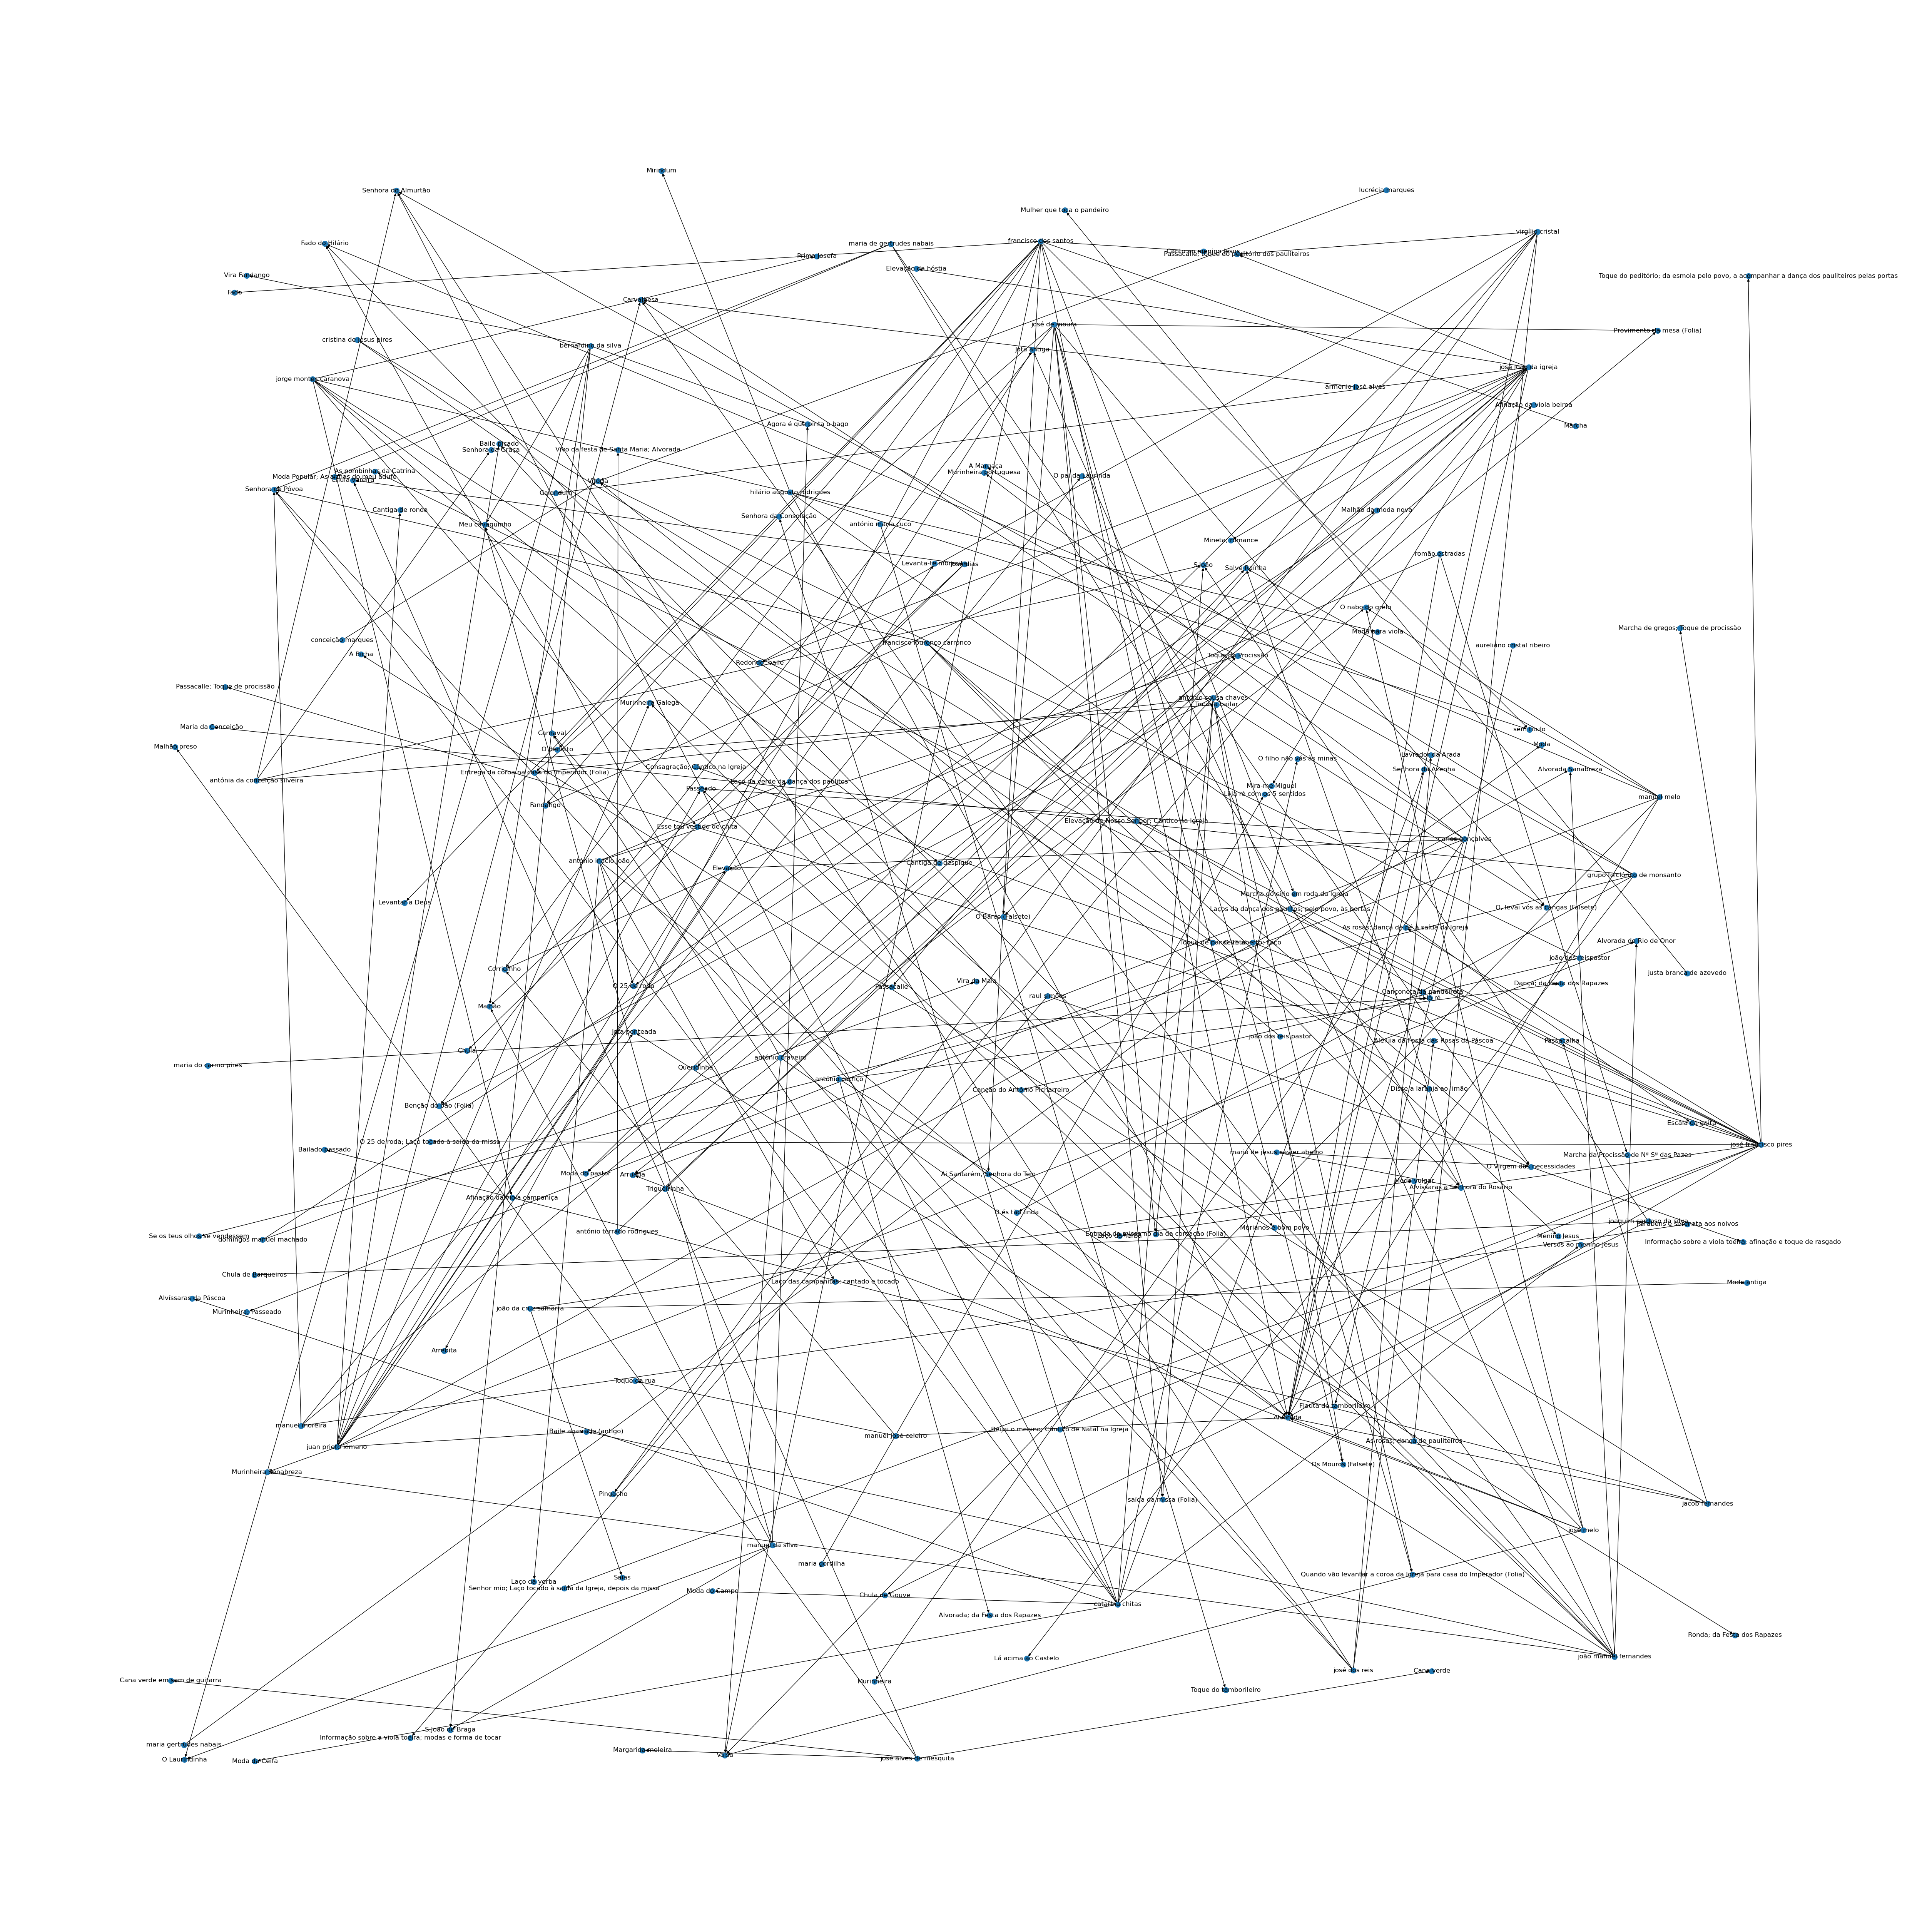

In [6]:
import collections
import re
import networkx as nx
import matplotlib.pyplot as plt
import webbrowser
import ftfy

# Abre o ficheiro de texto que vai ser analisado
f = open('arq-son.txt', 'r', encoding="utf-8")

# Devolve a provincía numa linha, como está sempre bem formatada não é necessário fazer modificações
def getProvince(line):
    return line[0]

# Devolve o local numa linha, no caso de termos "local, concelho" devolvemos só o concelho como pedido, caso contrário devolvemos o local
def getLocal(line):
    pattern = r',\s*(.*)$'
    match = re.search(pattern, line[1])
    if match:
        return match.group(1)
    else:
        return line[1]

# Devolve o título da canção numa linha, está sempre bem formatado então não modificamos nada
def getCancao(line):
    return line[2]

# Devolve uma lista com os instrumentos numa linha, temos 4 casos possíveis. Onde 3 deles, cada ocorrência está separada por ";"
# Pode estar no formato "(cantor) (instrumento)", "(instrumento e instrumento)", "(instrumento)"
# O caso final, é quando está em texto simples. Por exemplo: "clarinete". 
# Neste caso não conseguimos perceber se é um instrumento ou cantor então, verificamos se essa string já está no dicionário instrumentos e se estiver adicionamos à lista

def getInstrumentos(line):
    res = []
    line = re.split(';', line[3])

    pattern1 = r'\(.*\) (\D*)'    
    pattern2 = r'\((\D*) e (\D*)\)'
    pattern3 = r'(\((\D*)\))$'

    for pedaco in line:
        pedaco = pedaco.strip()
        match1 = re.search(pattern1, pedaco)
        match2 = re.search(pattern2, pedaco)
        match3 = re.search(pattern3, pedaco)
        if match1:
            res.append(match1.group(1).lower())
        elif match2:
            res.append(match2.group(1).lower())
            res.append(match2.group(2).lower())
        elif match3:
            res.append(match3.group(2).lower())
        elif pedaco in instrumentos:
            res.append(pedaco.lower())

    return res


# Devolve uma lista de musicos numa linha, temos 2 casos possíveis. Cada ocorrência é separada por ";"
# No primeiro caso, temos "musicos (instrumento)". O segundo caso é estar em texto simples como por exemplo "Zés Pereiras"
# Neste caso, verificamos se está no dicionário de musicos. No caso de estar adicionamos à lista.

def getMusicos(line):
    res = []
    line = re.split(';', line[3])
    
    pattern1 = r'(.+?) +\(\D*\)'

    for pedaco in line:
        pedaco = pedaco.strip()
        match1 = re.search(pattern1, pedaco)
        if match1:
            res.append(match1.group(1).lower())
        elif pedaco in musicos:
            res.append(pedaco.lower())
    return res
    

# Provincia::LocalOrig::Titulo::Musicos::SuporteDigital::...

# Correção dos caracteres ilegíveis
s = ftfy.fix_text(f.read())

# Separação do ficheiro por linhas
v = re.split(r'\n', s, flags=re.MULTILINE)

# Separação de cada linha por "::", separando cada um dos campos
arr = [re.split('::', i) for i in v[1:]]

# Remoção dos "\n" no final de cada linha
arr = [line[:-1] for line in arr] 

# Remoção das linhas que não tem o número mínimo campos correto
for i in range(len(arr)-1, -1, -1):
    if len(arr[i]) < 6:
        del arr[i]

# ------------- a) -------------

# Criação de dicionários para guardar as províncias e os locais
prov = collections.defaultdict(int)
loc = collections.defaultdict(int)

# Cálculo das ocorrências de cada província e de cada local
for line in arr:
    prov[getProvince(line)] += 1
    loc[getLocal(line)] += 1

# Ordenar por ordem alfabética
prov = dict(sorted(prov.items(), key=lambda item: item[0], reverse=False))
loc = dict(sorted(loc.items(), key=lambda item: item[0], reverse=False))

# ------------- b) -------------

# Criação de lista para guardar as músicas com suporte para MP3
comMP3 = []
semMP3 = []

# Verificação do suporte de MP3 em cada linha
for line in arr:
    if re.search(r"\.mp3", line[-2]):
        comMP3.append(getCancao(line))
    else:
        semMP3.append(getCancao(line))

# Cálculo da percentagem de músicas que suportam MP3
percent = len(comMP3) / len(arr) * 100

# Eliminação de músicas repetidas para simplificar a visualização dos resultados
comMP3 = list(set(comMP3))

# ------------- c) -------------

# Criação de dicionário para guardar os instrumentos
instrumentos = collections.defaultdict(int)

# Criação de lista para guardar as linhas que não estão bem formatadas para no final de percorrermos as linhas,
# voltarmos a percorrer estas linhas para adicionar possíveis ocorrências de instrumentos.
# Isto aconteceria no caso de um instrumento aparecer numa linha num formato não possível de identificar como instrumento,
# mas numa linha futura aparece esse instrumento no formato correto
vazia = []

# Cálculo do número de ocorrências de cada instrumento, no caso da lista devolvida não ter um instrumento, 
# a linha é adicionada à lista de linhas que vai ser percorrida novamente
for line in arr:
    inst = getInstrumentos(line)
    if len(inst) == 0:
        vazia.append(line)
    else:
        for i in inst:
            instrumentos[i] += 1

# Cálculo de possíveis ocorrências extra de instrumentos nas linhas não formatadas referidas anteriormente
for line in vazia:
    for i in getInstrumentos(line):
        instrumentos[i] += 1

# Ordenar o dicionário por ordem decrescente para vermos a distribuição de instrumentos
instrumentos = dict(sorted(instrumentos.items(), key=lambda item: item[0], reverse=False))

# ------------- d) -------------

# Criação de dicionário para guardar os músicos
musicos = collections.defaultdict(int)

# Criação de lista vazia para o mesmo efeito que dito na última alínea
vazia = []

# Cálculo do número de ocorrências de cada músico através do mesmo processo da alínea c)
for line in arr:
    musc = getMusicos(line)
    if len(musc) == 0:
        vazia.append(line)
    for i in musc:
        musicos[i] += 1

# Cálculo de possíveis ocorrências extra de músicos como na alínea c)
for line in vazia:
    for i in getMusicos(line):
        musicos[i] += 1

# Ordenar por ordem alfabética
musicos = dict(sorted(musicos.items(), key=lambda item: item[0], reverse=False))

# ------------- e) -------------

# Criação de dicionário para guardar que musicos tocam/cantam cada canção
adjList = collections.defaultdict(list)

# Preenchimento do dicionário com os músicos de cada canção
for line in arr:
    cancao = getCancao(line)
    for i in getMusicos(line):
        if i not in adjList[cancao]:
            adjList[cancao].append(i)

# Criação do grafo direcionado
grafo = nx.DiGraph()

# Adição dos nodos e arestas através dos dados no dicionário
for cancao, cantores in adjList.items():
    grafo.add_node(cancao)
    for cantor in cantores:
        grafo.add_node(cantor)
        grafo.add_edge(cantor, cancao)

# Criação do ficheiro .dot para futura visualização em websites como webgraphviz.com
nx.nx_pydot.write_dot(grafo, "musicas_cantores_grafo.dot")

# Definição do layout do grafo, neste caso foi escolhido o random para os nodos não se sobreporem
pos = nx.random_layout(grafo)

# Definição do tamanho da imagem e  desenho do grafo
plt.figure(figsize=(50, 50))
nx.draw(grafo, pos, with_labels=True, node_size=100)

# Guardar o grafo como um png para poder ser visto no html
plt.savefig("graph_visualization.png")


# ------------ Geração do ficheiro html ------------

# Abre/Cria um ficheiro html
with open('plc23TP1gr2.html', 'w') as file:

    # Cabeçalho inicial
    file.write('<html>\n<head>\n<title>plc23TP1gr2</title>\n</head>\n<body>\n')

    # A)
    file.write('<p style="font-size: 24px;">Calcular a frequência de registos por Província e por Local.</p>\n')
    
    # Provincias
    file.write('<table border="1">\n')
    file.write('<table border="1" style="width: 300px;">\n')
    file.write('<tr><th>Provincia</th><th>Registos</th></tr>\n')
    for i, j in prov.items():
        file.write(f'<tr><td>{i}</td><td>{j}</td></tr>\n')
    file.write('</table>\n')

    # Locais
    file.write('<table border="1">\n')
    file.write('<table border="1" style="width: 300px;">\n')
    file.write('<tr><th>Local</th><th>Registos</th></tr>\n')
    for i, j in loc.items():
        file.write(f'<tr><td>{i}</td><td>{j}</td></tr>\n')
    file.write('</table>\n')
    
    
    # B)
    file.write('<p style="font-size: 24px;">Calcular a percentagem de canções que têm pelo menos uma gravação "mp3."</p>\n')
    
    file.write(f'<p>Percentagem: {percent}%</p>')

    file.write('<table border="1">\n')
    file.write('<table border="1" style="width: 300px;">\n')
    file.write('<tr><th>Musica</th><th>Suporte MP3</th></tr>\n')

    arr.sort(key = lambda line: getCancao(line))

    for line in arr:
        mus = getCancao(line)
        if mus in comMP3:
            file.write(f'<tr><td>{mus}</td><td>Sim</td></tr>\n')
        elif mus in semMP3:
            file.write(f'<tr><td>{mus}</td><td>Não</td></tr>\n')
    file.write('</table>\n')
    
    
    # C)
    file.write('<p style="font-size: 24px;">Calcular a distribuição por instrumento musical.</p>\n')

    file.write('<table border="1">\n')
    file.write('<table border="1" style="width: 300px;">\n')
    file.write('<tr><th>Provincia</th><th>Registos</th></tr>\n')
    for i, j in instrumentos.items():
        file.write(f'<tr><td>{i}</td><td>{j}</td></tr>\n')
    file.write('</table>\n')
    
    
    # D)
    file.write('<p style="font-size: 24px;">Identificar todos os Musicos e calcular o número de vezes que são mencionados.</p>\n')
    file.write('<table border="1">\n')
    file.write('<table border="1" style="width: 300px;">\n')
    file.write('<tr><th>Músicos</th><th>Registos</th></tr>\n')
    for i, j in musicos.items():
        file.write(f'<tr><td>{i}</td><td>{j}</td></tr>\n')
    file.write('</table>\n')
    
    
    file.write('</body>\n</html>')

    # E)
    file.write('<p style="font-size: 24px;">Construir um Grafo de Canções/Cantores que associa cada canção aos cantores/tocadores referidos no registo.</p>\n')
    file.write('<img src="graph_visualization.png" alt="Grafo Canções/Cantores">')

# Abre o ficheiro html automaticamente
webbrowser.open('plc23TP1gr2.html')